#Neural Style Transfer

From 2015 paper of Neural Algorithm of Artistic Style https://arxiv.org/pdf/1508.06576.pdf <br><br>
Humans are great at creative things, such as art<br>
We don't understand well why humans are able to do this<br>
No artificial intelligence system exist that can create art parallel to human<br>
Can we have an algorithmic understanding how humans create art? <br>


## Overview:<br><br>
 1) Start with a content Image to preserve content and a Style Image whose style will be preserved.<br>
 2) Initialize a generated Image with wide noise <br>
 3) Try to loss function which approximate the content image and style image combined to generate a combination of two image. <br>
 4) The final generated Image will be approximation of content image and style image.


In [0]:
import keras.backend as K
from keras.applications import VGG16

from PIL import Image

import numpy as np
import time

from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave

import matplotlib.pyplot as plt
import tensorflow as tf

**Important Points<br><br>
1) There is no model learning in this study<br>
2) Only Image reconstruction is involved.<br>
2) Requires a frozen VGG16 model<br>
3) Requires only a pair of Content Image and Style Image , no other dataset is required.<br>
**

**
Content Image : Image for which content will be preserved<br>
Style Image : Image to transfer the style <br>
Generated Image : The output Image which will have the content of content image but will have style of style image.<br>
**

## **Input Content Image and Style Image**

![alt text](https://www.pyimagesearch.com/wp-content/uploads/2017/03/imagenet_vgg16.png)

**
1) We will be using a pre-trained CNN VGG16 to get representation of Input , Style and Generated Images in different layers of VGG16 model.<br>
2) VGG16 architecture as mentioned below takes input image size of (224, 224, 3) , so we need to resize our image to required size.<br>
3) VGG-16 is trained using Caffe, and Caffe uses OpenCV to load images which uses BGR by default, so VGG16 models takes BGR image as input.<br> 
4) We apply mean subtraction for faster convergence.
**

In [0]:
def process_img(path):
    # Open image and resize it
    img = Image.open(path)
    img = img.resize((img_width, img_height))

    # Convert image to data array
    data = np.asarray(img, dtype='float32')
    data = np.expand_dims(data, axis=0)
    data = data[:, :, :, :3]

    # Apply pre-process to match VGG16 we are using
    data[:, :, :, 0] -= 103.939
    data[:, :, :, 1] -= 116.779
    data[:, :, :, 2] -= 123.68

    # Flip from RGB to BGR
    data = data[:, :, :, ::-1]

    return data

**Loading Content Image and Style Image**

In [0]:
img_height = 224
img_width = 224
img_size = img_height * img_width
img_channels = 3

content_path = "content.jpg"
style_path = "sea_style.jpeg"

In [0]:
content = process_img(content_path)
style = process_img(style_path)

Text(0.5, 1.0, 'STYLE IMAGE')

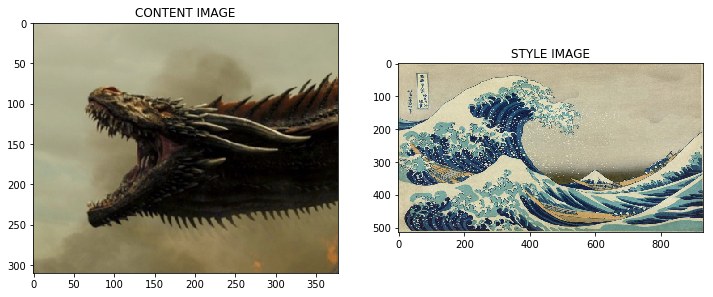

In [318]:
plt.figure(figsize=(12,10))
plt.subplot(121)
plt.imshow(Image.open(content_path))
plt.title("CONTENT IMAGE")
plt.subplot(122)
plt.imshow(Image.open(style_path))
plt.title("STYLE IMAGE")

**Prepare the generated image**

* Initialize the generated Image with random values and later update the image by transfering content image and style image and minimizing the loss discussed below.

In [0]:
def re_invert_image(img):
    # Reshape image and flip from BGR to RGB
    img = img.reshape((img_height, img_width, 3))
    img = img[:, :, ::-1]

    # Re-apply the mean shift
    img[:, :, 0] += 103.939
    img[:, :, 1] += 116.779
    img[:, :, 2] += 123.68

    # Clip values to 0-255
    img = np.clip(img, 0, 255).astype('uint8')

    plt.imshow(Image.fromarray(img))

In [0]:
# Initialization
generated_img = np.random.uniform(0, 255, (1, img_height, img_width, 3)) - 128.

Initial generated Image


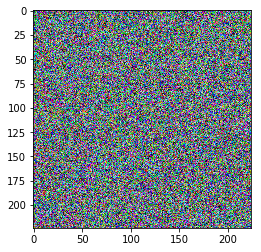

In [321]:
print("Initial generated Image")
re_invert_image(generated_img)

In [322]:
print(content.shape)
print(style.shape)
print(generated_img.shape)

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


In [0]:
# Define some variables
content_image = K.variable(content)
style_image = K.variable(style)
generated_image = K.placeholder((1, img_height, img_width, 3))
loss = K.variable(0.)

* generated image tensor is defined as placeholder because its tensor will be updated

## VGG16 model Representation

* Shallow layers have VGG16 model result in perfect reconstruction  so we cannot manipulate content image much<br>
* Deep layers have VGG16 model captures high level or overall objects and loose up some details.<br>
* As we go in deep network content becomes more blurry and we loose content of image <br>
* So we use mid layers of VGG16 network to capture representation of content Image

In [0]:
def get_layers(content_matrix, style_matrix, generated_matrix):
    input_tensor = K.concatenate([content_matrix, style_matrix, generated_matrix], axis=0)
    model = VGG16(input_tensor=input_tensor, weights='imagenet', include_top=False)

    # Convert layers to dictionary
    layers = dict([(layer.name, layer.output) for layer in model.layers])
    return layers    

In [0]:
layers = get_layers(content_image, style_image, generated_image)

In [326]:
# key : value form of layer name vs tensor value
layers

{'block1_conv1': <tf.Tensor 'block1_conv1_9/Relu:0' shape=(3, 224, 224, 64) dtype=float32>,
 'block1_conv2': <tf.Tensor 'block1_conv2_9/Relu:0' shape=(3, 224, 224, 64) dtype=float32>,
 'block1_pool': <tf.Tensor 'block1_pool_9/MaxPool:0' shape=(3, 112, 112, 64) dtype=float32>,
 'block2_conv1': <tf.Tensor 'block2_conv1_9/Relu:0' shape=(3, 112, 112, 128) dtype=float32>,
 'block2_conv2': <tf.Tensor 'block2_conv2_9/Relu:0' shape=(3, 112, 112, 128) dtype=float32>,
 'block2_pool': <tf.Tensor 'block2_pool_9/MaxPool:0' shape=(3, 56, 56, 128) dtype=float32>,
 'block3_conv1': <tf.Tensor 'block3_conv1_9/Relu:0' shape=(3, 56, 56, 256) dtype=float32>,
 'block3_conv2': <tf.Tensor 'block3_conv2_9/Relu:0' shape=(3, 56, 56, 256) dtype=float32>,
 'block3_conv3': <tf.Tensor 'block3_conv3_9/Relu:0' shape=(3, 56, 56, 256) dtype=float32>,
 'block3_pool': <tf.Tensor 'block3_pool_9/MaxPool:0' shape=(3, 28, 28, 256) dtype=float32>,
 'block4_conv1': <tf.Tensor 'block4_conv1_9/Relu:0' shape=(3, 28, 28, 512) dtype

In [0]:
content_layer = layers['block2_conv2']
s_layers = ['block1_conv2', 'block2_conv2', 'block3_conv3', 'block4_conv3', 'block5_conv3']
style_layers = [layers[layer] for layer in s_layers]

# LOSS FUNCTION

**We minimize the total loss which is sum of content loss, style loss, variation loss**

![alt text](https://i.imgur.com/12VIfaT.png)
<br>
**
α : content_weight <br>
β : content_weight<br>
γ : content_weight <br>
<br>
c : content feature<br>
s : style feature<br>
g : generated feature<br>
**

In [0]:
def get_value(a):
  init_op = tf.initialize_all_variables()
  with tf.Session() as sess:
    sess.run(init_op)
    return (sess.run(a))

## **Content loss**

Element wise comparison of content feature and generated feature and comute Mean Square Error

In [0]:
def content_loss(content_features, generated_features):
  return 0.5 * K.sum(K.square(generated_features - content_features))

Text(0.5, 1.0, 'BLURRED IMAGE')

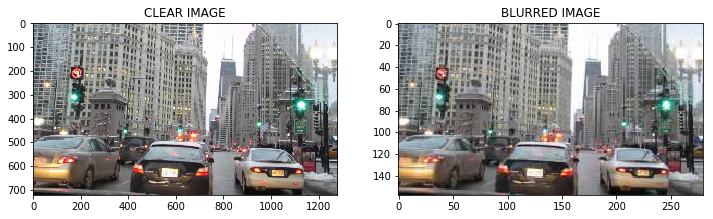

In [330]:
plt.figure(figsize=(12,10))
plt.subplot(121)
plt.imshow(Image.open("maxresdefault.jpg"))
plt.title("CLEAR IMAGE")
plt.subplot(122)
plt.imshow(Image.open("maxresdefault1 (1).jpg"))
plt.title("BLURRED IMAGE")

In [331]:
print("Content loss b/w above two images ",get_value(content_loss(K.variable(process_img("maxresdefault.jpg")),K.variable(process_img("maxresdefault1 (1).jpg")))))

Content loss b/w above two images  29208812.0


## **Style loss**

In [0]:
def gram_matrix(features):
  return K.dot(features, K.transpose(features))


def style_loss(style_matrix, generated_matrix):
    # Permute the matrix to calculate proper covariance
    style_features = K.batch_flatten(K.permute_dimensions(style_matrix, (2, 0, 1)))
    generated_features = K.batch_flatten(K.permute_dimensions(generated_matrix, (2, 0, 1)))

    # Get the gram matrices
    style_mat = gram_matrix(style_features)
    generated_mat = gram_matrix(generated_features)

    return K.sum(K.square(style_mat - generated_mat)) / (4.0 * (img_channels ** 2) * (img_size ** 2))

## **Variation loss**

In [0]:
def variation_loss(generated_matrix):
    a = K.square(generated_matrix[:, :img_height-1, :img_width-1, :] - generated_matrix[:, 1:, :img_width-1, :])
    b = K.square(generated_matrix[:, :img_height-1, :img_width-1, :] - generated_matrix[:, :img_height-1, 1:, :])

    return K.sum(K.pow(a + b, 1.25))

## **Total loss**

In [0]:
def total_loss(c_layer, s_layers, generated):
  
    content_weight = 1
    style_weight = 2
    variation_weight = 1

    # Content loss
    content_features = c_layer[0, :, :, :]
    generated_features = c_layer[2, :, :, :]
    c_loss = content_loss(content_features, generated_features)

    # Style loss
    s_loss = None
    for layer in s_layers:
        style_features = layer[1, :, :, :]
        generated_features = layer[2, :, :, :]
        if s_loss is None:
            s_loss = style_loss(style_features, generated_features) * (style_weight / len(s_layers))
        else:
            s_loss += style_loss(style_features, generated_features) * (style_weight / len(s_layers))

    # Variation loss (for regularization)
    v_loss = variation_loss(generated)

    return content_weight * c_loss + s_loss + variation_weight * v_loss

In [0]:
# Define loss and gradient
loss = total_loss(content_layer, style_layers, generated_image)
grads = K.gradients(loss, generated_image)

# Define the output
outputs = [loss]
outputs += grads
f_outputs = K.function([generated_image], outputs)

## Building an Evaluator
To optimize, we'll be using an algorithm called L-BFGS which is a little bit better for this task than just simple gradient descent. The problem is that we'll be using this from scipy, and it expects the data in a format that isn't how Keras naturally handles the gradients and loss. To rectify this, we construct an Evaluator class that stores this for us:

In [0]:
class Evaluator(object):
    """
    Evaluator class used to track gradients and loss values together
    """

    def __init__(self):
        self.loss_value = None
        self.grad_values = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

def eval_loss_and_grads(generated):
    generated = generated.reshape((1, img_height, img_width, 3))
    outs = f_outputs([generated])
    loss_value = outs[0]
    grad_values = outs[1].flatten().astype('float64')
    return loss_value, grad_values

**Save generated Image**

In [0]:
def save_image(filename, generated):
    # Reshape image and flip from BGR to RGB
    generated = generated.reshape((img_height, img_width, 3))
    generated = generated[:, :, ::-1]

    # Re-apply the mean shift
    generated[:, :, 0] += 103.939
    generated[:, :, 1] += 116.779
    generated[:, :, 2] += 123.68

    # Clip values to 0-255
    generated = np.clip(generated, 0, 255).astype('uint8')
    img_array = Image.fromarray(generated)
    imsave("output1/"+filename, img_array)

In [338]:
"""
import os
os.mkdir("output1")
"""

'\nimport os\nos.mkdir("output1")\n'

## Our Optimization Loop

In [339]:
evaluator = Evaluator()
iterations = 100

target_path = "output"
target_extension = ".jpg"

name = '{}-{}{}'.format(target_path, 0, target_extension)
save_image(name, generated_img)

for i in range(iterations):
    print('Iteration:', i)
    start_time = time.time()
    generated_img, min_val, info = fmin_l_bfgs_b(evaluator.loss, generated_img.flatten(),
                                                 fprime=evaluator.grads, maxfun=20)
    print('Loss:', min_val)
    end_time = time.time()
    print('Iteration {} took {} seconds'.format(i, end_time - start_time))
    name = '{}-{}{}'.format(target_path, i+1, target_extension)
    save_image(name, generated_img)
    print('Saved image to: {}'.format(name))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  


Iteration: 0
Loss: 82392340000.0
Iteration 0 took 2.4970703125 seconds
Saved image to: output-1.jpg
Iteration: 1
Loss: 72595890000.0
Iteration 1 took 1.4226670265197754 seconds
Saved image to: output-2.jpg
Iteration: 2
Loss: 71743910000.0
Iteration 2 took 1.4240238666534424 seconds
Saved image to: output-3.jpg
Iteration: 3
Loss: 71994980000.0
Iteration 3 took 1.426360845565796 seconds
Saved image to: output-4.jpg
Iteration: 4
Loss: 71045900000.0
Iteration 4 took 1.4423909187316895 seconds
Saved image to: output-5.jpg
Iteration: 5
Loss: 71904215000.0
Iteration 5 took 1.4344193935394287 seconds
Saved image to: output-6.jpg
Iteration: 6
Loss: 71590160000.0
Iteration 6 took 1.4747443199157715 seconds
Saved image to: output-7.jpg
Iteration: 7
Loss: 71132070000.0
Iteration 7 took 1.498809576034546 seconds
Saved image to: output-8.jpg
Iteration: 8
Loss: 71972350000.0
Iteration 8 took 1.4894788265228271 seconds
Saved image to: output-9.jpg
Iteration: 9
Loss: 71992490000.0
Iteration 9 took 1.48

**1st iteration Generated Image**

Text(0.5, 1.0, 'GENERATED IMAGE')

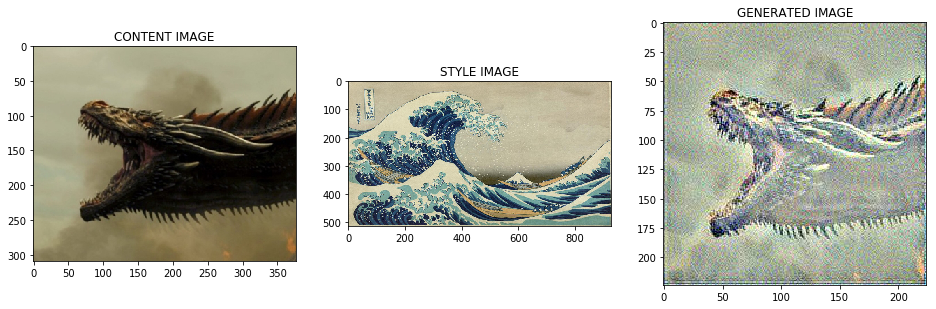

In [342]:
plt.figure(figsize=(16,10))
plt.subplot(131)
plt.imshow(Image.open(content_path))
plt.title("CONTENT IMAGE")
plt.subplot(132)
plt.imshow(Image.open(style_path))
plt.title("STYLE IMAGE")
plt.subplot(133)
plt.imshow(Image.open("output1/output-1.jpg"))
plt.title("GENERATED IMAGE")


**100th iteration Generated Image**

Text(0.5, 1.0, 'GENERATED IMAGE')

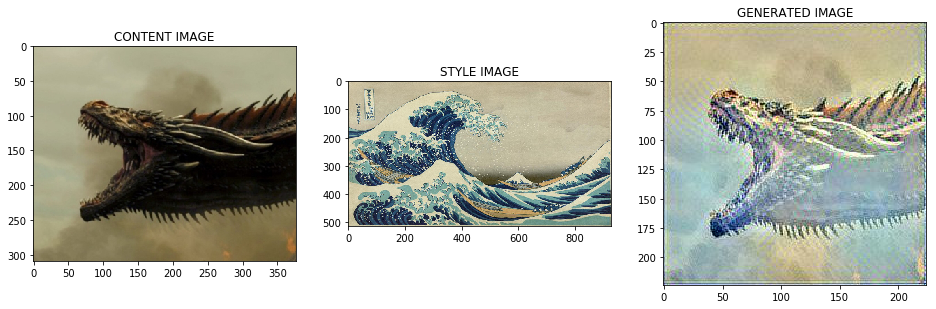

In [341]:
plt.figure(figsize=(16,10))
plt.subplot(131)
plt.imshow(Image.open(content_path))
plt.title("CONTENT IMAGE")
plt.subplot(132)
plt.imshow(Image.open(style_path))
plt.title("STYLE IMAGE")
plt.subplot(133)
plt.imshow(Image.open("output1/output-100.jpg"))
plt.title("GENERATED IMAGE")

## **Sources:**
*   Style transfer code by keras team : https://github.com/keras-team/keras/blob/master/examples/neural_style_transfer.py
*   Artistic Style paper : https://arxiv.org/pdf/1508.06576.pdf
*   https://harishnarayanan.org/writing/artistic-style-transfer/

